# Embedding of adjacency matrix with an optimization process

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register

from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform
import networkx as nx
from networkx.algorithms import approximation as approx
from scipy.optimize import minimize

from scipy.spatial.distance import pdist, squareform

The key idea is to encode the off-diagonal terms of the adjacency matrix by using the Rydberg interaction between atoms. As the interaction $U$ depends on the pairwise distance ($U = C_{6}/r_{ij}^6$) between atoms $i$ and $j$, we attempt to find the optimal positions of the atoms in the Register that replicate best the off-diagonal terms of the adjancecy matrix.

# 1.  Five atoms graph

Maximum independent set of G: {1, 3, 4}


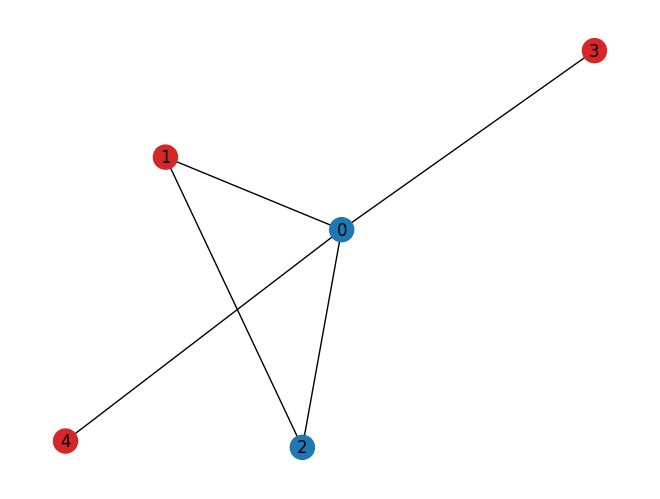

In [2]:
G = nx.Graph(
    [
        (0, 1),
        (0, 2),
        (0, 3),
        (0, 4),
        (1, 2),
    ]
) 

I = approx.maximum_independent_set(G)
print(f"Maximum independent set of G: {I}")

pos = nx.spring_layout(G) #, seed=39299899
nx.draw(
    G,
    pos=pos,
    with_labels=True,
    node_color=["tab:red" if n in I else "tab:blue" for n in G],
)

## 1.1 Embedding by hand

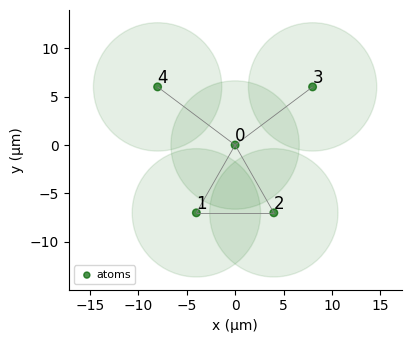

In [3]:
qubits = {'0': (0,0), '1': (-4,-7), '2': (4, -7), '3': (8,6), '4': (-8, 6)}
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

## 1.2 Embedding as an optimization process

In [4]:
adj_matrix_5_atoms =nx.adjacency_matrix(G).todense()

In [5]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    test, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(Chadoq2.interaction_coeff / pdist(new_coords) ** 6)
    return np.linalg.norm(new_Q - test)

Scale up the matrix for the optimization process

In [6]:
adj_matrix_5_atoms*3 

array([[0, 3, 3, 3, 3],
       [3, 0, 3, 0, 0],
       [3, 3, 0, 0, 0],
       [3, 0, 0, 0, 0],
       [3, 0, 0, 0, 0]])

In [7]:
shape = (len(adj_matrix_5_atoms), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(adj_matrix_5_atoms*3,shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(adj_matrix_5_atoms), 2))

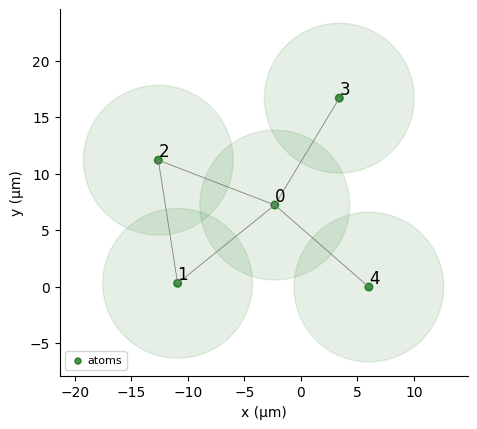

In [8]:
qubits_test = dict(enumerate(coords))
reg_test = Register(qubits_test)
reg_test.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

# 2. 8 atoms graph 

Maximum independent set of G: {2, 3, 4, 5}


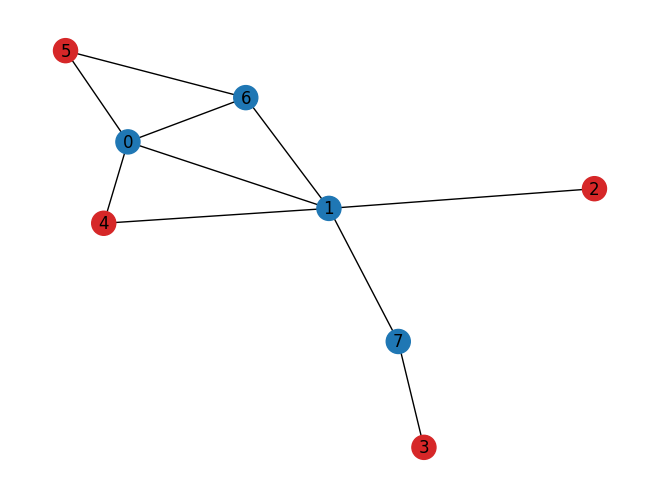

In [16]:
G_8 = nx.Graph(
    [
        (0, 1),
        (6, 1),
        (2, 1),
        (6, 5),
        (4, 1),
        (0, 4),
        (1, 7),
        (0, 6),
        (5, 0),
        (7, 3),
    ]
)

I = approx.maximum_independent_set(G_8)
print(f"Maximum independent set of G: {I}")

pos = nx.spring_layout(G_8, seed=39299899)
nx.draw(
    G_8,
    pos=pos,
    with_labels=True,
    node_color=["tab:red" if n in I else "tab:blue" for n in G_8],
)

## 2.1 Embedding by hand

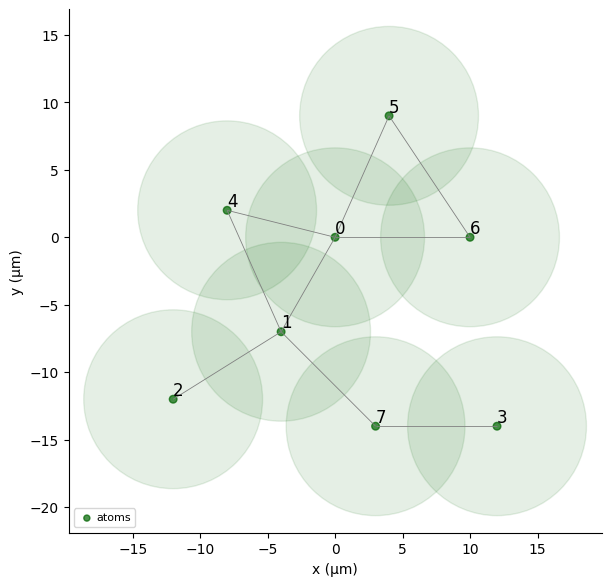

In [17]:
qubits = {'0': (0,0), '1': (-4,-7), '2': (-12, -12), '3': (12,-14), '4': (-8, 2),  '5': (4,9), '6': (10,0), '7': (3,-14)}
reg2 = Register(qubits) 
reg2.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

## 2.2 Embedding as an optimization process

In [18]:
adj_matrix_8_atoms =nx.adjacency_matrix(G_8).todense()

In [19]:
adj_matrix_8_atoms*2

array([[0, 2, 2, 0, 2, 2, 0, 0],
       [2, 0, 2, 2, 0, 2, 2, 0],
       [2, 2, 0, 0, 2, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0],
       [2, 0, 2, 0, 0, 0, 0, 0],
       [2, 2, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0, 0, 2, 0]])

In [20]:
shape = (len(adj_matrix_8_atoms), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(adj_matrix_8_atoms*2,shape), #*4
    method="COBYLA",
    tol=1e-6,
    options={"maxiter": 200000}, #, "maxfev": None
)
coords = np.reshape(res.x, (len(adj_matrix_8_atoms), 2))

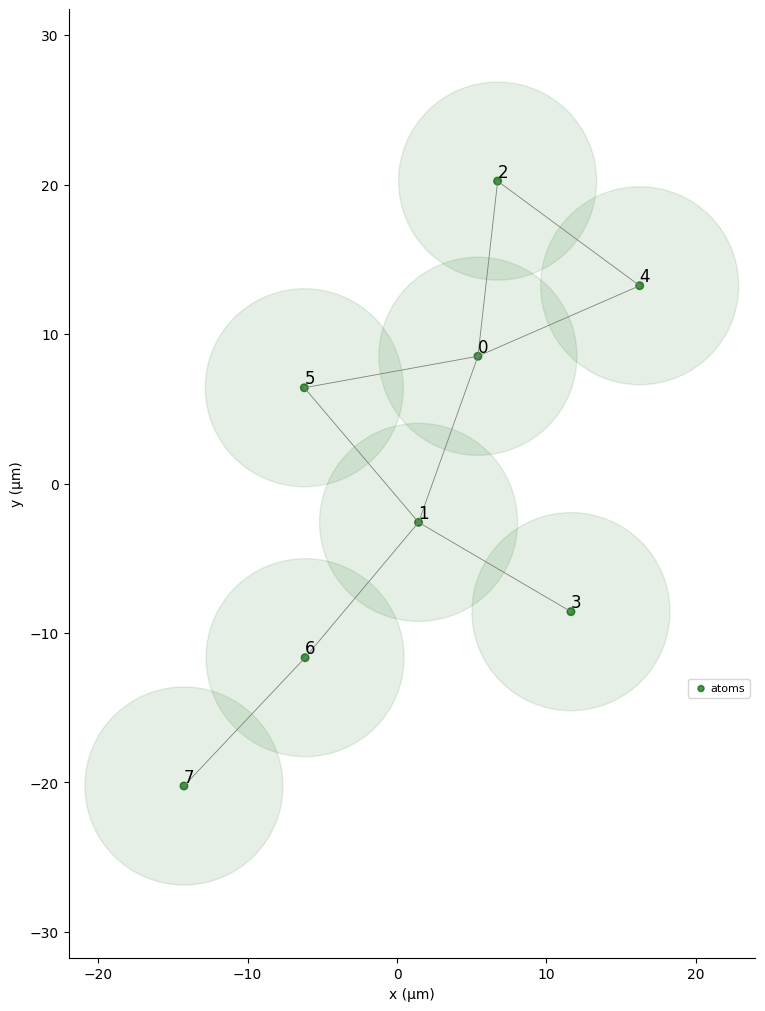

In [21]:
qubits_test_2 = dict(enumerate(coords))
reg_test = Register(qubits_test_2)
reg_test.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

# 3. 6 atoms

Maximum independent set of G: {0, 2, 3, 7}


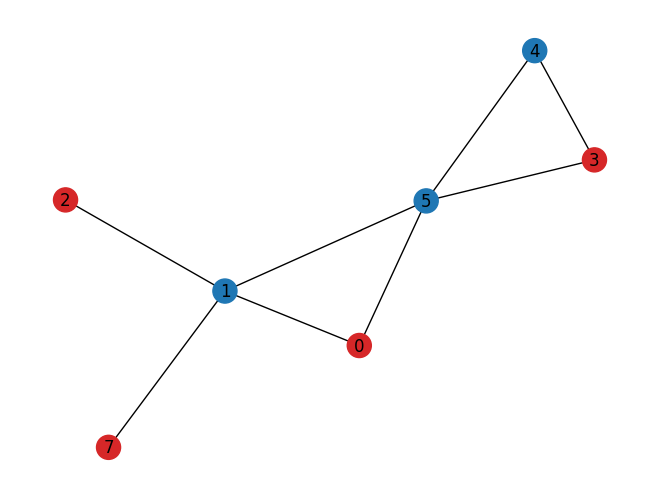

In [49]:
G_6 = nx.Graph(
    [
        (0, 1),
        (5, 1),
        (2, 1),
        (3, 5),
        (5, 4),
        (1, 7),
        (5, 0),
        (4, 3),
    ]
)

I = approx.maximum_independent_set(G_6)
print(f"Maximum independent set of G: {I}")

pos = nx.spring_layout(G_6)
nx.draw(
    G_6,
    pos=pos,
    with_labels=True,
    node_color=["tab:red" if n in I else "tab:blue" for n in G_6],
)

## 3.1 Embedding as an optimization process

In [43]:
adj_matrix_6_atoms =nx.adjacency_matrix(G_6).todense()

In [46]:
shape = (len(adj_matrix_6_atoms), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(adj_matrix_6_atoms*5,shape), #*4
    method="COBYLA",
    tol=1e-6,
    options={"maxiter": 200000}, #, "maxfev": None
)
coords_6_atoms = np.reshape(res.x, (len(adj_matrix_6_atoms), 2))

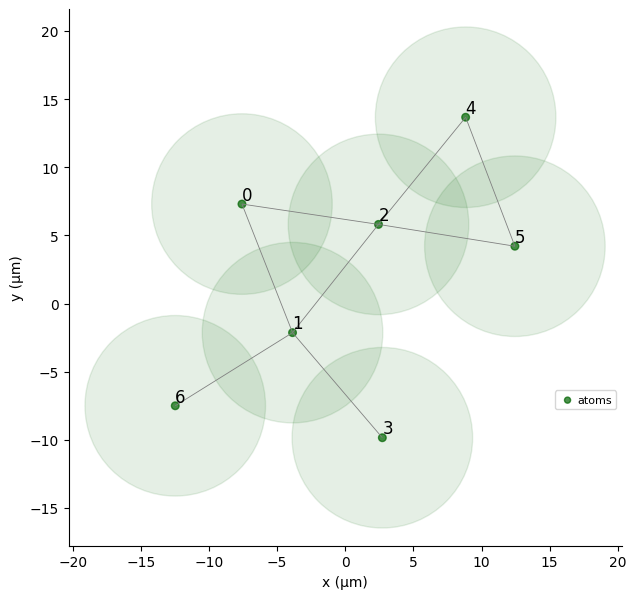

In [47]:
qubits_test_6_atoms = dict(enumerate(coords_6_atoms))
reg_test = Register(qubits_test_6_atoms)
reg_test.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)